# Pseudo labelling and consistency loss with cifar10 and resnet50

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.utils import save_image
from PIL import Image
from tqdm import tqdm

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
# Define data transforms
transform = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
])

# Load CIFAR-10 dataset
cifar10_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar10_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split CIFAR-10 train into labeled and unlabeled datasets
num_labeled = int(0.1 * len(cifar10_train))
num_unlabeled = len(cifar10_train) - num_labeled

indices = np.random.permutation(len(cifar10_train))
labeled_indices = indices[:num_labeled]
unlabeled_indices = indices[num_labeled:]

labeled_dataset = Subset(cifar10_train, labeled_indices)
unlabeled_dataset = Subset(cifar10_train, unlabeled_indices)

# Create DataLoaders
labeled_loader = DataLoader(labeled_dataset, batch_size=64, shuffle=True, num_workers=2)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(cifar10_test, batch_size=64, shuffle=False, num_workers=2)


100%|██████████| 170498071/170498071 [00:18<00:00, 9175513.63it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Define augmentation pipelines
strong_augmentations = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    transforms.ToTensor()
])

weak_augmentations = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

# Define directories
cifar10_dir = './data/CIFAR10'
strong_aug_dir = './data/CIFAR10/strong_aug'
weak_aug_dir = './data/CIFAR10/weak_aug'

# Create directories if they don't exist
os.makedirs(strong_aug_dir, exist_ok=True)
os.makedirs(weak_aug_dir, exist_ok=True)

# Function to save preprocessed images
def save_preprocessed_images(dataset, strong_aug_dir, weak_aug_dir, strong_augmentations, weak_augmentations):
    for i in range(len(dataset)):
        img, label = dataset[i]

        # Convert tensor to PIL Image
        img = transforms.ToPILImage()(img)

        # Apply strong augmentations
        strong_image = strong_augmentations(img)
        strong_img_path = os.path.join(strong_aug_dir, f'{i}.png')
        save_image(strong_image, strong_img_path)

        # Apply weak augmentations
        weak_image = weak_augmentations(img)
        weak_img_path = os.path.join(weak_aug_dir, f'{i}.png')
        save_image(weak_image, weak_img_path)

# Save preprocessed images for CIFAR-10 train dataset
save_preprocessed_images(cifar10_train, strong_aug_dir, weak_aug_dir, strong_augmentations, weak_augmentations)


In [ ]:
class CIFAR10PreprocessedDataset(Dataset):
    def __init__(self, original_dataset, strong_aug_dir, weak_aug_dir, transform=None):
        self.original_dataset = original_dataset
        self.strong_aug_dir = strong_aug_dir
        self.weak_aug_dir = weak_aug_dir
        self.transform = transform

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        img, label = self.original_dataset[idx]

        # Load preprocessed strong and weak images
        strong_img_path = os.path.join(self.strong_aug_dir, f'{idx}.png')
        weak_img_path = os.path.join(self.weak_aug_dir, f'{idx}.png')
        strong_image = Image.open(strong_img_path).convert('RGB')
        weak_image = Image.open(weak_img_path).convert('RGB')

        # Apply transform only to loaded strong and weak images
        if self.transform:
            strong_image = self.transform(strong_image)
            weak_image = self.transform(weak_image)

        return img, strong_image, weak_image, label

# Define transforms for loading images
load_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
])

# Initialize datasets and dataloaders
labeled_dataset = CIFAR10PreprocessedDataset(labeled_dataset, strong_aug_dir, weak_aug_dir, transform=load_transform)
unlabeled_dataset = CIFAR10PreprocessedDataset(unlabeled_dataset, strong_aug_dir, weak_aug_dir, transform=load_transform)

labeled_loader = DataLoader(labeled_dataset, batch_size=64, shuffle=True, num_workers=2)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(cifar10_test, batch_size=64, shuffle=False, num_workers=2)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Function to calculate test accuracy
def test_accuracy(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Function to calculate train accuracy
def train_accuracy(model, labeled_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, _, _, labels in labeled_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [ ]:
# Load a pre-trained ResNet50 model
weights = models.ResNet50_Weights.DEFAULT
resnet50 = models.resnet50(weights=weights)
num_classes = 10  # CIFAR-10 has 10 classes
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)
resnet50 = resnet50.to(device)

lu_weight = 1.0   # Weight for the unsupervised loss
lr = 0.03
momentum = 0.9

# Define the optimizer and criterion
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

# Define the optimizer
optimizer = optim.SGD(resnet50.parameters(), lr=lr, momentum=momentum, weight_decay=0.01)

# Define the cosine annealing scheduler
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
# optimizer = optimizer = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9) # optim.Adam(resnet50.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Function to generate pseudo-labels
def generate_pseudo_labels(model, images, threshold=0.95):
    model.eval()
    with torch.no_grad():
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        max_probs, pseudo_labels = torch.max(probs, dim=1)
        mask = max_probs > threshold
    model.train()
    return pseudo_labels, mask

# Consistency loss function
def consistency_loss(logits_weak, logits_strong):
    return nn.CrossEntropyLoss()(logits_weak, logits_strong)

# Training function with pseudo-labeling and consistency loss
def train_with_pseudo_labeling(model, labeled_loader, unlabeled_loader, criterion, optimizer, device, threshold=0.95, sup_train_epochs = 10):
    model.train()
    running_loss = 0.0
    for (labeled_images, labeled_strong_images, labeled_weak_images, labels), (unlabeled_images, strong_images, weak_images, _) in zip(tqdm(labeled_loader), unlabeled_loader):
        labeled_images, labeled_strong_images, labeled_weak_images = labeled_images.to(device), labeled_strong_images.to(device), labeled_weak_images.to(device)
        unlabeled_images, strong_images, weak_images = unlabeled_images.to(device), strong_images.to(device), weak_images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Generate pseudo-labels for weakly augmented images
        pseudo_labels, mask = generate_pseudo_labels(model, weak_images, threshold)

        # Forward pass for labeled images
        logits_labeled = model(labeled_images)
        supervised_loss = criterion(logits_labeled, labels)

        # Forward pass for unlabeled images
        logits_weak = model(weak_images)
        logits_strong = model(strong_images)

        # Calculate pseudo-labels and confidence indicator
        with torch.no_grad():
            uw_prob = torch.nn.functional.softmax(logits_weak.detach(), dim=1)
            max_prob, hard_label = torch.max(uw_prob, dim=1)
            indicator = max_prob > threshold

        # Calculate unsupervised loss
        unsupervised_loss = (criterion(logits_strong, hard_label) * indicator).mean()
        # if unsupervised_loss:
        #   print( unsupervised_loss)
        # Combine losses
        loss = supervised_loss + unsupervised_loss * lu_weight

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    scheduler.step()
    epoch_loss = running_loss / len(labeled_loader)
    return epoch_loss

# Training loop with pseudo-labeling and consistency loss
train_accuracies = []
test_accuracies = []
train_losses = []
num_epochs = 150
for epoch in range(num_epochs):
    train_loss = train_with_pseudo_labeling(resnet50, labeled_loader, unlabeled_loader, criterion, optimizer, device, threshold=0.95)
    test_acc = test_accuracy(resnet50, test_loader, device)
    train_acc = train_accuracy(resnet50, labeled_loader, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Accuracy: {test_acc:.2f}, Train Accuracy: {train_acc:.2f}%')




Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 181MB/s]
100%|██████████| 79/79 [00:21<00:00,  3.63it/s]


Epoch [1/150], Train Loss: 2.2777, Test Accuracy: 15.73, Train Accuracy: 15.34%


100%|██████████| 79/79 [00:19<00:00,  3.98it/s]


Epoch [2/150], Train Loss: 2.0535, Test Accuracy: 24.45, Train Accuracy: 25.74%


100%|██████████| 79/79 [00:19<00:00,  4.00it/s]


Epoch [3/150], Train Loss: 1.7684, Test Accuracy: 32.50, Train Accuracy: 32.62%


100%|██████████| 79/79 [00:18<00:00,  4.32it/s]


Epoch [4/150], Train Loss: 1.5767, Test Accuracy: 34.08, Train Accuracy: 34.18%


100%|██████████| 79/79 [00:18<00:00,  4.25it/s]


Epoch [5/150], Train Loss: 1.6327, Test Accuracy: 33.44, Train Accuracy: 33.98%


100%|██████████| 79/79 [00:21<00:00,  3.76it/s]


Epoch [6/150], Train Loss: 1.5337, Test Accuracy: 35.04, Train Accuracy: 36.22%


100%|██████████| 79/79 [00:18<00:00,  4.34it/s]


Epoch [7/150], Train Loss: 1.4539, Test Accuracy: 35.99, Train Accuracy: 36.58%


100%|██████████| 79/79 [00:20<00:00,  3.82it/s]


Epoch [8/150], Train Loss: 1.3817, Test Accuracy: 38.46, Train Accuracy: 38.06%


100%|██████████| 79/79 [00:20<00:00,  3.92it/s]


Epoch [9/150], Train Loss: 1.2960, Test Accuracy: 40.79, Train Accuracy: 42.98%


100%|██████████| 79/79 [00:18<00:00,  4.28it/s]


Epoch [10/150], Train Loss: 1.2719, Test Accuracy: 40.79, Train Accuracy: 41.90%


100%|██████████| 79/79 [00:19<00:00,  4.06it/s]


Epoch [11/150], Train Loss: 1.1984, Test Accuracy: 42.55, Train Accuracy: 45.48%


100%|██████████| 79/79 [00:18<00:00,  4.25it/s]


Epoch [12/150], Train Loss: 1.1779, Test Accuracy: 43.05, Train Accuracy: 45.76%


100%|██████████| 79/79 [00:19<00:00,  4.04it/s]


Epoch [13/150], Train Loss: 1.1346, Test Accuracy: 45.48, Train Accuracy: 46.18%


100%|██████████| 79/79 [00:19<00:00,  4.05it/s]


Epoch [14/150], Train Loss: 1.1410, Test Accuracy: 43.21, Train Accuracy: 45.20%


100%|██████████| 79/79 [00:18<00:00,  4.31it/s]


Epoch [15/150], Train Loss: 1.0982, Test Accuracy: 44.33, Train Accuracy: 45.48%


100%|██████████| 79/79 [00:19<00:00,  3.96it/s]


Epoch [16/150], Train Loss: 1.0766, Test Accuracy: 45.50, Train Accuracy: 46.50%


100%|██████████| 79/79 [00:19<00:00,  4.04it/s]


Epoch [17/150], Train Loss: 1.0679, Test Accuracy: 47.63, Train Accuracy: 49.70%


100%|██████████| 79/79 [00:18<00:00,  4.34it/s]


Epoch [18/150], Train Loss: 1.0297, Test Accuracy: 47.25, Train Accuracy: 49.74%


100%|██████████| 79/79 [00:19<00:00,  4.10it/s]


Epoch [19/150], Train Loss: 1.0187, Test Accuracy: 47.74, Train Accuracy: 50.70%


100%|██████████| 79/79 [00:20<00:00,  3.86it/s]


Epoch [20/150], Train Loss: 0.9914, Test Accuracy: 47.61, Train Accuracy: 51.86%


100%|██████████| 79/79 [00:18<00:00,  4.18it/s]


Epoch [21/150], Train Loss: 1.0039, Test Accuracy: 47.52, Train Accuracy: 51.22%


100%|██████████| 79/79 [00:19<00:00,  3.99it/s]


Epoch [22/150], Train Loss: 0.9780, Test Accuracy: 49.12, Train Accuracy: 52.12%


100%|██████████| 79/79 [00:18<00:00,  4.33it/s]


Epoch [23/150], Train Loss: 0.9539, Test Accuracy: 50.63, Train Accuracy: 54.44%


100%|██████████| 79/79 [00:18<00:00,  4.36it/s]


Epoch [24/150], Train Loss: 0.9211, Test Accuracy: 48.71, Train Accuracy: 51.20%


100%|██████████| 79/79 [00:19<00:00,  4.05it/s]


Epoch [25/150], Train Loss: 0.9518, Test Accuracy: 48.66, Train Accuracy: 53.02%


100%|██████████| 79/79 [00:18<00:00,  4.32it/s]


Epoch [26/150], Train Loss: 0.9054, Test Accuracy: 49.16, Train Accuracy: 53.58%


100%|██████████| 79/79 [00:18<00:00,  4.31it/s]


Epoch [27/150], Train Loss: 0.9161, Test Accuracy: 51.94, Train Accuracy: 55.26%


100%|██████████| 79/79 [00:20<00:00,  3.79it/s]


Epoch [28/150], Train Loss: 0.8839, Test Accuracy: 50.44, Train Accuracy: 55.02%


100%|██████████| 79/79 [00:18<00:00,  4.21it/s]


Epoch [29/150], Train Loss: 0.8556, Test Accuracy: 50.35, Train Accuracy: 54.68%


100%|██████████| 79/79 [00:19<00:00,  4.02it/s]


Epoch [30/150], Train Loss: 0.8734, Test Accuracy: 51.80, Train Accuracy: 57.76%


100%|██████████| 79/79 [00:18<00:00,  4.17it/s]


Epoch [31/150], Train Loss: 0.8898, Test Accuracy: 51.20, Train Accuracy: 55.96%


100%|██████████| 79/79 [00:18<00:00,  4.30it/s]


Epoch [32/150], Train Loss: 0.8490, Test Accuracy: 50.54, Train Accuracy: 55.62%


100%|██████████| 79/79 [00:21<00:00,  3.74it/s]


Epoch [33/150], Train Loss: 0.8280, Test Accuracy: 52.04, Train Accuracy: 56.68%


100%|██████████| 79/79 [00:18<00:00,  4.18it/s]


Epoch [34/150], Train Loss: 0.8169, Test Accuracy: 51.66, Train Accuracy: 57.40%


100%|██████████| 79/79 [00:18<00:00,  4.32it/s]


Epoch [35/150], Train Loss: 0.8284, Test Accuracy: 53.62, Train Accuracy: 58.44%


100%|██████████| 79/79 [00:21<00:00,  3.76it/s]


Epoch [36/150], Train Loss: 0.7823, Test Accuracy: 54.13, Train Accuracy: 59.20%


100%|██████████| 79/79 [00:18<00:00,  4.32it/s]


Epoch [37/150], Train Loss: 0.7962, Test Accuracy: 51.88, Train Accuracy: 56.58%


100%|██████████| 79/79 [00:19<00:00,  4.12it/s]


Epoch [38/150], Train Loss: 0.7775, Test Accuracy: 51.29, Train Accuracy: 55.02%


100%|██████████| 79/79 [00:23<00:00,  3.32it/s]


Epoch [39/150], Train Loss: 0.7756, Test Accuracy: 53.58, Train Accuracy: 57.94%


100%|██████████| 79/79 [00:18<00:00,  4.23it/s]


Epoch [40/150], Train Loss: 0.7370, Test Accuracy: 51.55, Train Accuracy: 56.98%


100%|██████████| 79/79 [00:20<00:00,  3.95it/s]


Epoch [41/150], Train Loss: 0.7278, Test Accuracy: 51.96, Train Accuracy: 56.22%


100%|██████████| 79/79 [00:22<00:00,  3.57it/s]


Epoch [42/150], Train Loss: 0.7289, Test Accuracy: 53.01, Train Accuracy: 59.12%


100%|██████████| 79/79 [00:19<00:00,  4.08it/s]


Epoch [43/150], Train Loss: 0.7248, Test Accuracy: 53.49, Train Accuracy: 59.86%


100%|██████████| 79/79 [00:19<00:00,  4.01it/s]


Epoch [44/150], Train Loss: 0.7260, Test Accuracy: 52.58, Train Accuracy: 57.50%


100%|██████████| 79/79 [00:18<00:00,  4.26it/s]


Epoch [45/150], Train Loss: 0.7139, Test Accuracy: 51.51, Train Accuracy: 56.86%


100%|██████████| 79/79 [00:20<00:00,  3.94it/s]


Epoch [46/150], Train Loss: 0.6928, Test Accuracy: 50.78, Train Accuracy: 55.04%


100%|██████████| 79/79 [00:19<00:00,  4.05it/s]


Epoch [47/150], Train Loss: 0.8210, Test Accuracy: 51.49, Train Accuracy: 57.08%


100%|██████████| 79/79 [00:18<00:00,  4.29it/s]


Epoch [48/150], Train Loss: 0.7763, Test Accuracy: 51.50, Train Accuracy: 57.68%


100%|██████████| 79/79 [00:21<00:00,  3.73it/s]


Epoch [49/150], Train Loss: 0.7215, Test Accuracy: 53.61, Train Accuracy: 58.94%


100%|██████████| 79/79 [00:18<00:00,  4.21it/s]


Epoch [50/150], Train Loss: 0.7215, Test Accuracy: 52.63, Train Accuracy: 57.02%


100%|██████████| 79/79 [00:18<00:00,  4.28it/s]


Epoch [51/150], Train Loss: 0.7164, Test Accuracy: 53.24, Train Accuracy: 58.42%


100%|██████████| 79/79 [00:19<00:00,  4.00it/s]


Epoch [52/150], Train Loss: 0.6784, Test Accuracy: 54.42, Train Accuracy: 59.38%


100%|██████████| 79/79 [00:19<00:00,  3.99it/s]


Epoch [53/150], Train Loss: 0.6777, Test Accuracy: 53.77, Train Accuracy: 60.34%


100%|██████████| 79/79 [00:20<00:00,  3.79it/s]


Epoch [54/150], Train Loss: 0.6594, Test Accuracy: 53.19, Train Accuracy: 59.80%


100%|██████████| 79/79 [00:19<00:00,  4.10it/s]


Epoch [55/150], Train Loss: 0.6857, Test Accuracy: 52.96, Train Accuracy: 58.76%


100%|██████████| 79/79 [00:20<00:00,  3.92it/s]


Epoch [56/150], Train Loss: 0.6636, Test Accuracy: 52.56, Train Accuracy: 58.58%


100%|██████████| 79/79 [00:24<00:00,  3.23it/s]


Epoch [57/150], Train Loss: 0.6641, Test Accuracy: 55.15, Train Accuracy: 61.64%


100%|██████████| 79/79 [00:18<00:00,  4.23it/s]


Epoch [58/150], Train Loss: 0.6499, Test Accuracy: 54.77, Train Accuracy: 61.38%


100%|██████████| 79/79 [00:21<00:00,  3.62it/s]


Epoch [59/150], Train Loss: 0.6321, Test Accuracy: 52.44, Train Accuracy: 57.80%


100%|██████████| 79/79 [00:21<00:00,  3.75it/s]


Epoch [60/150], Train Loss: 0.6571, Test Accuracy: 55.70, Train Accuracy: 60.46%


100%|██████████| 79/79 [00:19<00:00,  3.98it/s]


Epoch [61/150], Train Loss: 0.6398, Test Accuracy: 54.15, Train Accuracy: 60.72%


100%|██████████| 79/79 [00:18<00:00,  4.27it/s]


Epoch [62/150], Train Loss: 0.6205, Test Accuracy: 52.72, Train Accuracy: 58.52%


100%|██████████| 79/79 [00:18<00:00,  4.30it/s]


Epoch [63/150], Train Loss: 0.6029, Test Accuracy: 53.39, Train Accuracy: 60.26%


100%|██████████| 79/79 [00:20<00:00,  3.89it/s]


Epoch [64/150], Train Loss: 0.6172, Test Accuracy: 53.74, Train Accuracy: 59.18%


100%|██████████| 79/79 [00:20<00:00,  3.86it/s]


Epoch [65/150], Train Loss: 0.6369, Test Accuracy: 52.97, Train Accuracy: 59.18%


100%|██████████| 79/79 [00:19<00:00,  3.98it/s]


Epoch [66/150], Train Loss: 0.5972, Test Accuracy: 52.91, Train Accuracy: 59.36%


100%|██████████| 79/79 [00:18<00:00,  4.25it/s]


Epoch [67/150], Train Loss: 0.5925, Test Accuracy: 51.40, Train Accuracy: 56.76%


100%|██████████| 79/79 [00:20<00:00,  3.93it/s]


Epoch [68/150], Train Loss: 0.5968, Test Accuracy: 53.70, Train Accuracy: 59.48%


100%|██████████| 79/79 [00:21<00:00,  3.74it/s]


KeyboardInterrupt: 

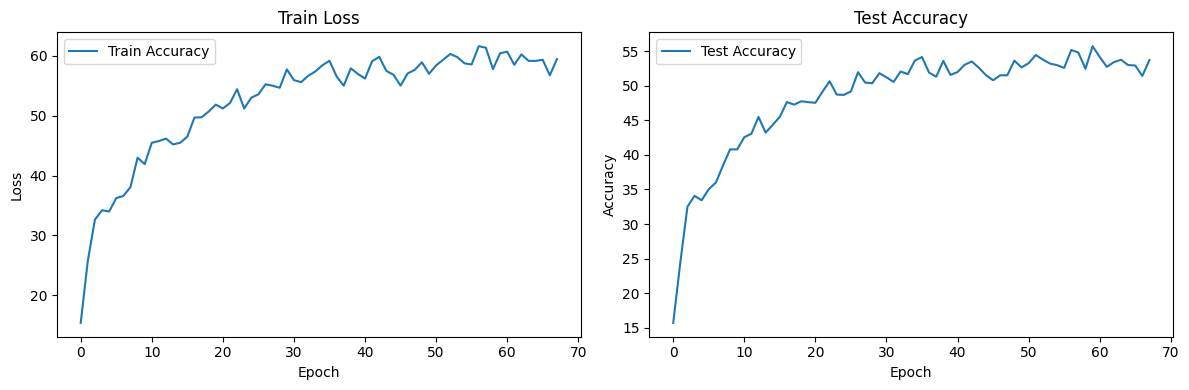

In [ ]:
import matplotlib.pyplot as plt

# Plotting the results
epochs = np.arange(1, 68)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## To do

2.4 Additional important factors
Semi-supervised performance can be substantially impacted by factors other than the SSL algorithm
used because considerations like the amount of regularization can be particularly important in the
low-label regime. This is compounded by the fact that the performance of deep networks trained for
image classification can heavily depend on the architecture, optimizer, training schedule, etc. These
factors are typically not emphasized when new SSL algorithms are introduced. Instead, we endeavor
to quantify their importance and highlight which ones have a significant impact on performance.
Most analysis is performed in section 5. In this section we identify a few key considerations.
First, as mentioned above, we find that regularization is particularly important. In all of our models and
experiments, we use simple weight decay regularization. We also found that using the Adam optimizer
[22] resulted in worse performance and instead use standard SGD with momentum [50, 40, 34]. We
did not find a substantial difference between standard and Nesterov momentum. For a learning rate
schedule, we use a cosine learning rate decay [28] which sets the learning rate to η cos
7πk
16K

where
η is the initial learning rate, k is the current training step, and K is the total number of training steps.
Finally, we report final performance using an exponential moving average of model parameters

In [ ]:
# Load a pre-trained ResNet50 model
weights = models.ResNet50_Weights.DEFAULT
resnet50 = models.resnet50(weights=weights)
num_classes = 10  # CIFAR-10 has 10 classes
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)
resnet50 = resnet50.to(device)

lu_weight = 1.0   # Weight for the unsupervised loss
lr = 0.03
momentum = 0.9
weight_decay = 5e-4
# Define the optimizer and criterion
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

# Define the optimizer
optimizer = optim.SGD(resnet50.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

# Define the cosine annealing scheduler
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
# optimizer = optimizer = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9) # optim.Adam(resnet50.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Function to generate pseudo-labels
def generate_pseudo_labels(model, images, threshold=0.95):
    model.eval()
    with torch.no_grad():
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        max_probs, pseudo_labels = torch.max(probs, dim=1)
        mask = max_probs > threshold
    model.train()
    return pseudo_labels, mask

# Consistency loss function
def consistency_loss(logits_weak, logits_strong):
    return nn.CrossEntropyLoss()(logits_weak, logits_strong)

# Training function with pseudo-labeling and consistency loss
def train_with_pseudo_labeling(model, labeled_loader, unlabeled_loader, criterion, optimizer, device, threshold=0.95, sup_train_epochs = 10):
    model.train()
    running_loss = 0.0
    for (labeled_images, labeled_strong_images, labeled_weak_images, labels), (unlabeled_images, strong_images, weak_images, _) in zip(tqdm(labeled_loader), unlabeled_loader):
        labeled_images, labeled_strong_images, labeled_weak_images = labeled_images.to(device), labeled_strong_images.to(device), labeled_weak_images.to(device)
        unlabeled_images, strong_images, weak_images = unlabeled_images.to(device), strong_images.to(device), weak_images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Generate pseudo-labels for weakly augmented images
        pseudo_labels, mask = generate_pseudo_labels(model, weak_images, threshold)

        # Forward pass for labeled images
        logits_labeled = model(labeled_images)
        supervised_loss = criterion(logits_labeled, labels)

        # Forward pass for unlabeled images
        logits_weak = model(weak_images)
        logits_strong = model(strong_images)

        # Calculate pseudo-labels and confidence indicator
        with torch.no_grad():
            uw_prob = torch.nn.functional.softmax(logits_weak.detach(), dim=1)
            max_prob, hard_label = torch.max(uw_prob, dim=1)
            indicator = max_prob > threshold

        # Calculate unsupervised loss
        unsupervised_loss = (criterion(logits_strong, hard_label) * indicator).mean()
        # if unsupervised_loss:
        #   print( unsupervised_loss)
        # Combine losses
        loss = supervised_loss + unsupervised_loss * lu_weight

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    scheduler.step()
    epoch_loss = running_loss / len(labeled_loader)
    return epoch_loss

# Training loop with pseudo-labeling and consistency loss
train_accuracies = []
test_accuracies = []
train_losses = []
num_epochs = 150
for epoch in range(num_epochs):
    train_loss = train_with_pseudo_labeling(resnet50, labeled_loader, unlabeled_loader, criterion, optimizer, device, threshold=0.95)
    test_acc = test_accuracy(resnet50, test_loader, device)
    train_acc = train_accuracy(resnet50, labeled_loader, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Accuracy: {test_acc:.2f}, Train Accuracy: {train_acc:.2f}%')

100%|██████████| 79/79 [00:22<00:00,  3.56it/s]


Epoch [1/150], Train Loss: 2.1149, Test Accuracy: 24.03, Train Accuracy: 24.44%


100%|██████████| 79/79 [00:18<00:00,  4.22it/s]


Epoch [2/150], Train Loss: 1.9156, Test Accuracy: 30.62, Train Accuracy: 31.08%


100%|██████████| 79/79 [00:19<00:00,  3.97it/s]


Epoch [3/150], Train Loss: 1.8910, Test Accuracy: 30.19, Train Accuracy: 29.92%


100%|██████████| 79/79 [00:19<00:00,  4.01it/s]


Epoch [4/150], Train Loss: 1.7332, Test Accuracy: 34.18, Train Accuracy: 35.50%


100%|██████████| 79/79 [00:21<00:00,  3.74it/s]


Epoch [5/150], Train Loss: 1.6851, Test Accuracy: 27.32, Train Accuracy: 27.12%


100%|██████████| 79/79 [00:20<00:00,  3.88it/s]


Epoch [6/150], Train Loss: 1.8044, Test Accuracy: 31.87, Train Accuracy: 32.42%


100%|██████████| 79/79 [00:19<00:00,  4.05it/s]


Epoch [7/150], Train Loss: 1.7767, Test Accuracy: 34.36, Train Accuracy: 34.96%


100%|██████████| 79/79 [00:19<00:00,  3.96it/s]


Epoch [8/150], Train Loss: 1.6784, Test Accuracy: 37.17, Train Accuracy: 37.94%


100%|██████████| 79/79 [00:18<00:00,  4.26it/s]


Epoch [9/150], Train Loss: 1.6219, Test Accuracy: 33.08, Train Accuracy: 35.10%


100%|██████████| 79/79 [00:19<00:00,  3.95it/s]


Epoch [10/150], Train Loss: 1.5564, Test Accuracy: 38.37, Train Accuracy: 38.22%


100%|██████████| 79/79 [00:19<00:00,  3.96it/s]


Epoch [11/150], Train Loss: 1.5481, Test Accuracy: 35.92, Train Accuracy: 37.00%


100%|██████████| 79/79 [00:19<00:00,  4.11it/s]


Epoch [12/150], Train Loss: 1.4877, Test Accuracy: 39.48, Train Accuracy: 41.24%


100%|██████████| 79/79 [00:19<00:00,  4.16it/s]


Epoch [13/150], Train Loss: 1.4251, Test Accuracy: 37.47, Train Accuracy: 39.36%


100%|██████████| 79/79 [00:20<00:00,  3.85it/s]


Epoch [14/150], Train Loss: 1.4151, Test Accuracy: 40.30, Train Accuracy: 42.56%


100%|██████████| 79/79 [00:19<00:00,  4.06it/s]


Epoch [15/150], Train Loss: 1.4922, Test Accuracy: 43.10, Train Accuracy: 46.28%


100%|██████████| 79/79 [00:18<00:00,  4.22it/s]


Epoch [16/150], Train Loss: 1.4088, Test Accuracy: 34.49, Train Accuracy: 35.52%


100%|██████████| 79/79 [00:20<00:00,  3.92it/s]


Epoch [17/150], Train Loss: 1.6436, Test Accuracy: 36.65, Train Accuracy: 38.60%


100%|██████████| 79/79 [00:18<00:00,  4.20it/s]


Epoch [18/150], Train Loss: 1.5079, Test Accuracy: 41.84, Train Accuracy: 43.52%


100%|██████████| 79/79 [00:21<00:00,  3.64it/s]


Epoch [19/150], Train Loss: 1.4428, Test Accuracy: 41.56, Train Accuracy: 44.22%


100%|██████████| 79/79 [00:20<00:00,  3.88it/s]


Epoch [20/150], Train Loss: 1.3662, Test Accuracy: 44.58, Train Accuracy: 47.12%


100%|██████████| 79/79 [00:18<00:00,  4.21it/s]


Epoch [21/150], Train Loss: 1.3395, Test Accuracy: 41.54, Train Accuracy: 43.52%


100%|██████████| 79/79 [00:20<00:00,  3.91it/s]


Epoch [22/150], Train Loss: 1.4080, Test Accuracy: 44.24, Train Accuracy: 47.40%


100%|██████████| 79/79 [00:18<00:00,  4.17it/s]


Epoch [23/150], Train Loss: 1.3228, Test Accuracy: 45.18, Train Accuracy: 47.90%


100%|██████████| 79/79 [00:21<00:00,  3.62it/s]


Epoch [24/150], Train Loss: 1.3051, Test Accuracy: 44.27, Train Accuracy: 47.50%


100%|██████████| 79/79 [00:20<00:00,  3.85it/s]


Epoch [25/150], Train Loss: 1.2417, Test Accuracy: 37.35, Train Accuracy: 38.98%


100%|██████████| 79/79 [00:19<00:00,  4.10it/s]


Epoch [26/150], Train Loss: 1.5636, Test Accuracy: 39.58, Train Accuracy: 41.62%


100%|██████████| 79/79 [00:19<00:00,  4.12it/s]


Epoch [27/150], Train Loss: 1.3556, Test Accuracy: 43.27, Train Accuracy: 46.10%


100%|██████████| 79/79 [00:19<00:00,  4.13it/s]


Epoch [28/150], Train Loss: 1.2817, Test Accuracy: 42.43, Train Accuracy: 45.68%


100%|██████████| 79/79 [00:20<00:00,  3.91it/s]


Epoch [29/150], Train Loss: 1.2354, Test Accuracy: 44.59, Train Accuracy: 47.48%


100%|██████████| 79/79 [00:20<00:00,  3.91it/s]


Epoch [30/150], Train Loss: 1.2531, Test Accuracy: 48.06, Train Accuracy: 51.02%


100%|██████████| 79/79 [00:20<00:00,  3.91it/s]


Epoch [31/150], Train Loss: 1.3511, Test Accuracy: 46.18, Train Accuracy: 48.94%


100%|██████████| 79/79 [00:18<00:00,  4.19it/s]


Epoch [32/150], Train Loss: 1.2312, Test Accuracy: 41.83, Train Accuracy: 44.58%


100%|██████████| 79/79 [00:21<00:00,  3.67it/s]


Epoch [33/150], Train Loss: 1.1703, Test Accuracy: 42.71, Train Accuracy: 46.46%


100%|██████████| 79/79 [00:18<00:00,  4.21it/s]


Epoch [34/150], Train Loss: 1.1729, Test Accuracy: 47.54, Train Accuracy: 50.30%


100%|██████████| 79/79 [00:18<00:00,  4.23it/s]


Epoch [35/150], Train Loss: 1.1420, Test Accuracy: 44.28, Train Accuracy: 47.58%


100%|██████████| 79/79 [00:19<00:00,  3.99it/s]


Epoch [36/150], Train Loss: 1.1039, Test Accuracy: 42.46, Train Accuracy: 44.88%


100%|██████████| 79/79 [00:18<00:00,  4.21it/s]


Epoch [37/150], Train Loss: 1.1149, Test Accuracy: 45.32, Train Accuracy: 50.04%


100%|██████████| 79/79 [00:21<00:00,  3.75it/s]


Epoch [38/150], Train Loss: 1.1279, Test Accuracy: 42.95, Train Accuracy: 46.18%


100%|██████████| 79/79 [00:20<00:00,  3.92it/s]


Epoch [39/150], Train Loss: 1.0552, Test Accuracy: 44.15, Train Accuracy: 47.86%


100%|██████████| 79/79 [00:18<00:00,  4.28it/s]


Epoch [40/150], Train Loss: 1.0471, Test Accuracy: 44.53, Train Accuracy: 49.44%


100%|██████████| 79/79 [00:19<00:00,  4.00it/s]


Epoch [41/150], Train Loss: 1.0578, Test Accuracy: 45.44, Train Accuracy: 50.62%


100%|██████████| 79/79 [00:19<00:00,  4.02it/s]


Epoch [42/150], Train Loss: 1.1337, Test Accuracy: 43.07, Train Accuracy: 46.40%


100%|██████████| 79/79 [00:20<00:00,  3.84it/s]


Epoch [43/150], Train Loss: 1.0524, Test Accuracy: 45.16, Train Accuracy: 49.12%


100%|██████████| 79/79 [00:20<00:00,  3.78it/s]


Epoch [44/150], Train Loss: 1.0291, Test Accuracy: 45.20, Train Accuracy: 47.60%


100%|██████████| 79/79 [00:18<00:00,  4.25it/s]


Epoch [45/150], Train Loss: 1.0849, Test Accuracy: 42.78, Train Accuracy: 46.88%


100%|██████████| 79/79 [00:19<00:00,  3.95it/s]


Epoch [46/150], Train Loss: 1.0622, Test Accuracy: 47.00, Train Accuracy: 49.84%


100%|██████████| 79/79 [00:18<00:00,  4.22it/s]


Epoch [47/150], Train Loss: 1.0128, Test Accuracy: 47.42, Train Accuracy: 52.24%


100%|██████████| 79/79 [00:18<00:00,  4.17it/s]


Epoch [48/150], Train Loss: 1.0631, Test Accuracy: 44.51, Train Accuracy: 48.62%


100%|██████████| 79/79 [00:21<00:00,  3.72it/s]


Epoch [49/150], Train Loss: 1.0424, Test Accuracy: 47.89, Train Accuracy: 52.78%


100%|██████████| 79/79 [00:18<00:00,  4.17it/s]


Epoch [50/150], Train Loss: 1.0095, Test Accuracy: 44.09, Train Accuracy: 48.52%


100%|██████████| 79/79 [00:19<00:00,  3.96it/s]


Epoch [51/150], Train Loss: 0.9817, Test Accuracy: 46.01, Train Accuracy: 50.12%


100%|██████████| 79/79 [00:20<00:00,  3.91it/s]


Epoch [52/150], Train Loss: 0.9805, Test Accuracy: 46.59, Train Accuracy: 51.94%


100%|██████████| 79/79 [00:18<00:00,  4.22it/s]


Epoch [53/150], Train Loss: 1.0281, Test Accuracy: 45.71, Train Accuracy: 51.76%


100%|██████████| 79/79 [00:20<00:00,  3.92it/s]


Epoch [54/150], Train Loss: 1.1707, Test Accuracy: 45.96, Train Accuracy: 51.04%


100%|██████████| 79/79 [00:19<00:00,  4.15it/s]


Epoch [55/150], Train Loss: 0.9887, Test Accuracy: 42.55, Train Accuracy: 47.44%


100%|██████████| 79/79 [00:19<00:00,  3.95it/s]


Epoch [56/150], Train Loss: 1.2266, Test Accuracy: 43.09, Train Accuracy: 47.50%


100%|██████████| 79/79 [00:20<00:00,  3.88it/s]


Epoch [57/150], Train Loss: 1.0340, Test Accuracy: 45.36, Train Accuracy: 50.28%


100%|██████████| 79/79 [00:20<00:00,  3.91it/s]


Epoch [58/150], Train Loss: 0.9576, Test Accuracy: 48.65, Train Accuracy: 53.88%


100%|██████████| 79/79 [00:20<00:00,  3.94it/s]


Epoch [59/150], Train Loss: 0.9252, Test Accuracy: 45.35, Train Accuracy: 50.98%


100%|██████████| 79/79 [00:18<00:00,  4.27it/s]


Epoch [60/150], Train Loss: 1.0435, Test Accuracy: 43.57, Train Accuracy: 49.68%


100%|██████████| 79/79 [00:18<00:00,  4.24it/s]


Epoch [61/150], Train Loss: 0.9173, Test Accuracy: 45.64, Train Accuracy: 50.22%


100%|██████████| 79/79 [00:19<00:00,  4.12it/s]


Epoch [62/150], Train Loss: 0.8864, Test Accuracy: 48.61, Train Accuracy: 52.90%


100%|██████████| 79/79 [00:19<00:00,  3.97it/s]


Epoch [63/150], Train Loss: 0.8388, Test Accuracy: 46.07, Train Accuracy: 53.14%


100%|██████████| 79/79 [00:20<00:00,  3.94it/s]


Epoch [64/150], Train Loss: 0.8229, Test Accuracy: 46.55, Train Accuracy: 51.04%


100%|██████████| 79/79 [00:19<00:00,  4.04it/s]


Epoch [65/150], Train Loss: 0.8144, Test Accuracy: 50.04, Train Accuracy: 55.38%


100%|██████████| 79/79 [00:18<00:00,  4.25it/s]


Epoch [66/150], Train Loss: 0.7783, Test Accuracy: 49.82, Train Accuracy: 56.46%


100%|██████████| 79/79 [00:19<00:00,  3.98it/s]


Epoch [67/150], Train Loss: 0.7397, Test Accuracy: 49.45, Train Accuracy: 54.92%


100%|██████████| 79/79 [00:20<00:00,  3.93it/s]


Epoch [68/150], Train Loss: 0.7654, Test Accuracy: 48.07, Train Accuracy: 52.68%


100%|██████████| 79/79 [00:20<00:00,  3.94it/s]


Epoch [69/150], Train Loss: 0.7524, Test Accuracy: 48.21, Train Accuracy: 53.56%


100%|██████████| 79/79 [00:19<00:00,  3.98it/s]


Epoch [70/150], Train Loss: 0.7211, Test Accuracy: 48.37, Train Accuracy: 54.22%


100%|██████████| 79/79 [00:18<00:00,  4.23it/s]


Epoch [71/150], Train Loss: 0.7306, Test Accuracy: 50.93, Train Accuracy: 57.32%


100%|██████████| 79/79 [00:20<00:00,  3.93it/s]


Epoch [72/150], Train Loss: 0.6960, Test Accuracy: 50.70, Train Accuracy: 56.26%


100%|██████████| 79/79 [00:18<00:00,  4.27it/s]


Epoch [73/150], Train Loss: 0.6952, Test Accuracy: 49.19, Train Accuracy: 55.94%


100%|██████████| 79/79 [00:20<00:00,  3.95it/s]


Epoch [74/150], Train Loss: 0.6607, Test Accuracy: 50.48, Train Accuracy: 56.76%


100%|██████████| 79/79 [00:19<00:00,  4.07it/s]


Epoch [75/150], Train Loss: 0.6482, Test Accuracy: 48.48, Train Accuracy: 56.28%


100%|██████████| 79/79 [00:18<00:00,  4.29it/s]


Epoch [76/150], Train Loss: 0.6285, Test Accuracy: 46.69, Train Accuracy: 54.16%


100%|██████████| 79/79 [00:20<00:00,  3.82it/s]


Epoch [77/150], Train Loss: 0.6260, Test Accuracy: 49.05, Train Accuracy: 56.78%


100%|██████████| 79/79 [00:18<00:00,  4.19it/s]


Epoch [78/150], Train Loss: 0.6324, Test Accuracy: 49.38, Train Accuracy: 56.74%


100%|██████████| 79/79 [00:18<00:00,  4.29it/s]


Epoch [79/150], Train Loss: 0.6372, Test Accuracy: 49.16, Train Accuracy: 58.78%


100%|██████████| 79/79 [00:19<00:00,  3.96it/s]


Epoch [80/150], Train Loss: 0.6317, Test Accuracy: 49.77, Train Accuracy: 57.82%


100%|██████████| 79/79 [00:18<00:00,  4.28it/s]


Epoch [81/150], Train Loss: 0.6285, Test Accuracy: 48.79, Train Accuracy: 55.28%


100%|██████████| 79/79 [00:20<00:00,  3.82it/s]


Epoch [82/150], Train Loss: 0.6686, Test Accuracy: 49.34, Train Accuracy: 57.46%


100%|██████████| 79/79 [00:20<00:00,  3.79it/s]


Epoch [83/150], Train Loss: 0.6154, Test Accuracy: 50.18, Train Accuracy: 57.38%


100%|██████████| 79/79 [00:18<00:00,  4.27it/s]


Epoch [84/150], Train Loss: 0.5930, Test Accuracy: 50.67, Train Accuracy: 59.64%


100%|██████████| 79/79 [00:19<00:00,  3.96it/s]


Epoch [85/150], Train Loss: 0.6002, Test Accuracy: 48.96, Train Accuracy: 57.92%


100%|██████████| 79/79 [00:18<00:00,  4.26it/s]


Epoch [86/150], Train Loss: 0.5432, Test Accuracy: 49.40, Train Accuracy: 55.72%


100%|██████████| 79/79 [00:18<00:00,  4.18it/s]


Epoch [87/150], Train Loss: 0.5960, Test Accuracy: 49.46, Train Accuracy: 57.48%


100%|██████████| 79/79 [00:21<00:00,  3.73it/s]


Epoch [88/150], Train Loss: 0.5845, Test Accuracy: 49.23, Train Accuracy: 55.62%


100%|██████████| 79/79 [00:20<00:00,  3.95it/s]


Epoch [89/150], Train Loss: 0.5655, Test Accuracy: 50.45, Train Accuracy: 58.12%


100%|██████████| 79/79 [00:19<00:00,  3.98it/s]


Epoch [90/150], Train Loss: 0.5641, Test Accuracy: 51.21, Train Accuracy: 59.74%


100%|██████████| 79/79 [00:18<00:00,  4.24it/s]


Epoch [91/150], Train Loss: 0.5603, Test Accuracy: 49.21, Train Accuracy: 58.12%


100%|██████████| 79/79 [00:19<00:00,  4.11it/s]


Epoch [92/150], Train Loss: 0.5688, Test Accuracy: 50.21, Train Accuracy: 58.58%


100%|██████████| 79/79 [00:19<00:00,  4.02it/s]


Epoch [93/150], Train Loss: 0.5517, Test Accuracy: 52.46, Train Accuracy: 60.64%


100%|██████████| 79/79 [00:18<00:00,  4.21it/s]


Epoch [94/150], Train Loss: 0.5609, Test Accuracy: 50.08, Train Accuracy: 58.68%


100%|██████████| 79/79 [00:20<00:00,  3.79it/s]


Epoch [95/150], Train Loss: 0.5311, Test Accuracy: 50.82, Train Accuracy: 59.36%


100%|██████████| 79/79 [00:19<00:00,  4.13it/s]


Epoch [96/150], Train Loss: 0.5851, Test Accuracy: 50.96, Train Accuracy: 58.30%


100%|██████████| 79/79 [00:18<00:00,  4.24it/s]


Epoch [97/150], Train Loss: 0.5438, Test Accuracy: 49.36, Train Accuracy: 57.04%


100%|██████████| 79/79 [00:20<00:00,  3.79it/s]


Epoch [98/150], Train Loss: 0.5732, Test Accuracy: 49.38, Train Accuracy: 57.62%


100%|██████████| 79/79 [00:19<00:00,  4.11it/s]


Epoch [99/150], Train Loss: 0.5272, Test Accuracy: 50.57, Train Accuracy: 57.94%


100%|██████████| 79/79 [00:18<00:00,  4.23it/s]


Epoch [100/150], Train Loss: 0.5614, Test Accuracy: 51.73, Train Accuracy: 59.32%


100%|██████████| 79/79 [00:21<00:00,  3.72it/s]


Epoch [101/150], Train Loss: 0.5608, Test Accuracy: 50.34, Train Accuracy: 57.86%


100%|██████████| 79/79 [00:18<00:00,  4.20it/s]


Epoch [102/150], Train Loss: 0.5558, Test Accuracy: 52.46, Train Accuracy: 61.00%


100%|██████████| 79/79 [00:18<00:00,  4.21it/s]


Epoch [103/150], Train Loss: 0.5641, Test Accuracy: 49.76, Train Accuracy: 57.74%


100%|██████████| 79/79 [00:21<00:00,  3.68it/s]


Epoch [104/150], Train Loss: 0.5269, Test Accuracy: 50.68, Train Accuracy: 58.92%


100%|██████████| 79/79 [00:18<00:00,  4.24it/s]


Epoch [105/150], Train Loss: 0.5670, Test Accuracy: 51.01, Train Accuracy: 58.68%


100%|██████████| 79/79 [00:19<00:00,  3.95it/s]


Epoch [106/150], Train Loss: 0.5691, Test Accuracy: 51.07, Train Accuracy: 59.36%


100%|██████████| 79/79 [00:18<00:00,  4.22it/s]


Epoch [107/150], Train Loss: 0.5585, Test Accuracy: 50.17, Train Accuracy: 58.40%


100%|██████████| 79/79 [00:18<00:00,  4.23it/s]


Epoch [108/150], Train Loss: 0.5496, Test Accuracy: 51.85, Train Accuracy: 59.18%


100%|██████████| 79/79 [00:20<00:00,  3.95it/s]


Epoch [109/150], Train Loss: 0.5582, Test Accuracy: 50.73, Train Accuracy: 59.16%


100%|██████████| 79/79 [00:19<00:00,  3.97it/s]


Epoch [110/150], Train Loss: 0.5486, Test Accuracy: 51.61, Train Accuracy: 59.38%


100%|██████████| 79/79 [00:21<00:00,  3.74it/s]


Epoch [111/150], Train Loss: 0.5582, Test Accuracy: 50.87, Train Accuracy: 59.30%


100%|██████████| 79/79 [00:19<00:00,  4.08it/s]


Epoch [112/150], Train Loss: 0.5765, Test Accuracy: 50.27, Train Accuracy: 59.86%


100%|██████████| 79/79 [00:18<00:00,  4.23it/s]


Epoch [113/150], Train Loss: 0.5377, Test Accuracy: 49.53, Train Accuracy: 59.58%


100%|██████████| 79/79 [00:20<00:00,  3.94it/s]


Epoch [114/150], Train Loss: 0.5447, Test Accuracy: 50.33, Train Accuracy: 58.32%


100%|██████████| 79/79 [00:18<00:00,  4.24it/s]


Epoch [115/150], Train Loss: 0.5308, Test Accuracy: 49.72, Train Accuracy: 58.46%


100%|██████████| 79/79 [00:19<00:00,  3.97it/s]


Epoch [116/150], Train Loss: 0.5434, Test Accuracy: 49.15, Train Accuracy: 56.66%


100%|██████████| 79/79 [00:19<00:00,  3.95it/s]


Epoch [117/150], Train Loss: 0.5301, Test Accuracy: 50.62, Train Accuracy: 59.30%


100%|██████████| 79/79 [00:19<00:00,  4.04it/s]


Epoch [118/150], Train Loss: 0.5386, Test Accuracy: 44.36, Train Accuracy: 51.16%


100%|██████████| 79/79 [00:19<00:00,  4.01it/s]


Epoch [119/150], Train Loss: 1.7417, Test Accuracy: 34.86, Train Accuracy: 37.34%


100%|██████████| 79/79 [00:18<00:00,  4.29it/s]


Epoch [120/150], Train Loss: 1.4550, Test Accuracy: 40.51, Train Accuracy: 42.98%


100%|██████████| 79/79 [00:18<00:00,  4.32it/s]


Epoch [121/150], Train Loss: 1.2603, Test Accuracy: 44.08, Train Accuracy: 47.00%


100%|██████████| 79/79 [00:19<00:00,  4.15it/s]


Epoch [122/150], Train Loss: 1.1594, Test Accuracy: 43.56, Train Accuracy: 48.88%


100%|██████████| 79/79 [00:19<00:00,  4.05it/s]


Epoch [123/150], Train Loss: 1.0709, Test Accuracy: 45.73, Train Accuracy: 49.20%


100%|██████████| 79/79 [00:20<00:00,  3.84it/s]


Epoch [124/150], Train Loss: 1.0202, Test Accuracy: 47.33, Train Accuracy: 52.28%


100%|██████████| 79/79 [00:18<00:00,  4.28it/s]


Epoch [125/150], Train Loss: 0.9626, Test Accuracy: 47.52, Train Accuracy: 53.58%


100%|██████████| 79/79 [00:18<00:00,  4.36it/s]


Epoch [126/150], Train Loss: 0.9292, Test Accuracy: 49.12, Train Accuracy: 55.48%


100%|██████████| 79/79 [00:19<00:00,  4.07it/s]


Epoch [127/150], Train Loss: 0.8831, Test Accuracy: 48.46, Train Accuracy: 55.24%


100%|██████████| 79/79 [00:18<00:00,  4.28it/s]


Epoch [128/150], Train Loss: 1.0017, Test Accuracy: 45.89, Train Accuracy: 51.82%


 25%|██▌       | 20/79 [00:06<00:18,  3.22it/s]


KeyboardInterrupt: 

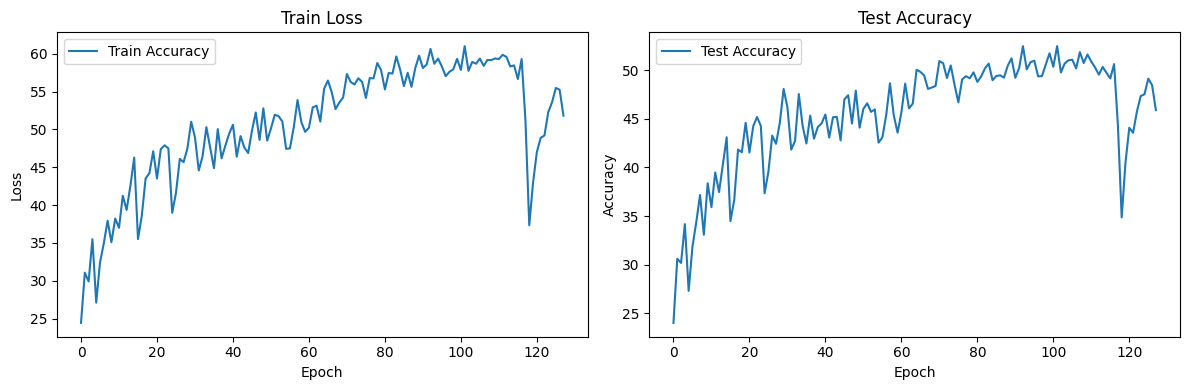

In [ ]:
import matplotlib.pyplot as plt

# Plotting the results
epochs = np.arange(1, 68)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.swa_utils import AveragedModel, SWALR

# Load a pre-trained ResNet50 model
weights = models.ResNet50_Weights.DEFAULT
resnet50 = models.resnet50(weights=weights)
num_classes = 10  # CIFAR-10 has 10 classes
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)
resnet50 = resnet50.to(device)

# Define the optimizer
optimizer = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)

# Define the cosine annealing scheduler
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

# Initialize EMA (Exponential Moving Average)
ema_model = AveragedModel(resnet50)
swa_scheduler = SWALR(optimizer, swa_lr=0.001)

criterion = nn.CrossEntropyLoss()

# Function to generate pseudo-labels
def generate_pseudo_labels(model, images, threshold=0.95):
    model.eval()
    with torch.no_grad():
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        max_probs, pseudo_labels = torch.max(probs, dim=1)
        mask = max_probs > threshold
    model.train()
    return pseudo_labels, mask

# Consistency loss function
def consistency_loss(logits_weak, logits_strong):
    return nn.CrossEntropyLoss()(logits_weak, logits_strong)

# Training function with pseudo-labeling and consistency loss
def train_with_pseudo_labeling(model, labeled_loader, unlabeled_loader, criterion, optimizer, scheduler, ema_model, device, threshold=0.95):
    model.train()
    running_loss = 0.0
    for (labeled_images, labeled_strong_images, labeled_weak_images, labels), (unlabeled_images, strong_images, weak_images, _) in zip(tqdm(labeled_loader), unlabeled_loader):
        labeled_images, labeled_strong_images, labeled_weak_images = labeled_images.to(device), labeled_strong_images.to(device), labeled_weak_images.to(device)
        unlabeled_images, strong_images, weak_images = unlabeled_images.to(device), strong_images.to(device), weak_images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Generate pseudo-labels for weakly augmented images
        pseudo_labels, mask = generate_pseudo_labels(model, weak_images, threshold)

        lu_weight = 1.0   # Weight for the unsupervised loss

        # Forward pass for labeled images
        logits_labeled = model(labeled_images)
        supervised_loss = criterion(logits_labeled, labels)

        # Forward pass for unlabeled images
        logits_weak = model(weak_images)
        logits_strong = model(strong_images)

        # Calculate pseudo-labels and confidence indicator
        with torch.no_grad():
            uw_prob = torch.nn.functional.softmax(logits_weak.detach(), dim=1)
            max_prob, hard_label = torch.max(uw_prob, dim=1)
            indicator = max_prob > threshold

        # Calculate unsupervised loss
        unsupervised_loss = (criterion(logits_strong, hard_label) * indicator).mean()

        # Combine losses
        loss = supervised_loss + unsupervised_loss * lu_weight

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Update EMA model
        ema_model.update_parameters(model)
        swa_scheduler.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(labeled_loader)
    return epoch_loss

# Training loop with pseudo-labeling and consistency loss
train_accuracies = []
test_accuracies = []
train_losses = []
num_epochs = 150
for epoch in range(num_epochs):
    train_loss = train_with_pseudo_labeling(resnet50, labeled_loader, unlabeled_loader, criterion, optimizer, scheduler, ema_model, device, threshold=0.95)
    test_acc = test_accuracy(resnet50, test_loader, device)
    train_acc = train_accuracy(resnet50, labeled_loader, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Accuracy: {test_acc:.2f}, Train Accuracy: {train_acc:.2f}%')


100%|██████████| 79/79 [00:18<00:00,  4.17it/s]


Epoch [1/150], Train Loss: 2.2372, Test Accuracy: 20.82, Train Accuracy: 20.20%


100%|██████████| 79/79 [00:20<00:00,  3.91it/s]


Epoch [2/150], Train Loss: 1.9588, Test Accuracy: 23.85, Train Accuracy: 23.94%


100%|██████████| 79/79 [00:18<00:00,  4.18it/s]


Epoch [3/150], Train Loss: 1.7450, Test Accuracy: 28.15, Train Accuracy: 28.34%


100%|██████████| 79/79 [00:20<00:00,  3.79it/s]


Epoch [4/150], Train Loss: 1.6073, Test Accuracy: 30.86, Train Accuracy: 31.70%


100%|██████████| 79/79 [00:21<00:00,  3.75it/s]


Epoch [5/150], Train Loss: 1.4974, Test Accuracy: 32.70, Train Accuracy: 33.78%


100%|██████████| 79/79 [00:19<00:00,  3.99it/s]


Epoch [6/150], Train Loss: 1.4424, Test Accuracy: 34.88, Train Accuracy: 34.18%


100%|██████████| 79/79 [00:20<00:00,  3.91it/s]


Epoch [7/150], Train Loss: 1.3707, Test Accuracy: 36.68, Train Accuracy: 37.40%


100%|██████████| 79/79 [00:19<00:00,  4.10it/s]


Epoch [8/150], Train Loss: 1.3278, Test Accuracy: 37.96, Train Accuracy: 38.54%


100%|██████████| 79/79 [00:21<00:00,  3.61it/s]


Epoch [9/150], Train Loss: 1.2819, Test Accuracy: 36.85, Train Accuracy: 37.68%


100%|██████████| 79/79 [00:18<00:00,  4.16it/s]


Epoch [10/150], Train Loss: 1.2227, Test Accuracy: 38.33, Train Accuracy: 39.14%


100%|██████████| 79/79 [00:21<00:00,  3.59it/s]


Epoch [11/150], Train Loss: 1.1976, Test Accuracy: 36.40, Train Accuracy: 37.52%


100%|██████████| 79/79 [00:20<00:00,  3.86it/s]


Epoch [12/150], Train Loss: 1.1460, Test Accuracy: 38.52, Train Accuracy: 39.40%


100%|██████████| 79/79 [00:20<00:00,  3.86it/s]


Epoch [13/150], Train Loss: 1.1187, Test Accuracy: 39.48, Train Accuracy: 42.58%


100%|██████████| 79/79 [00:19<00:00,  4.15it/s]


Epoch [14/150], Train Loss: 1.0950, Test Accuracy: 43.83, Train Accuracy: 45.76%


100%|██████████| 79/79 [00:21<00:00,  3.69it/s]


Epoch [15/150], Train Loss: 1.0709, Test Accuracy: 40.79, Train Accuracy: 41.70%


100%|██████████| 79/79 [00:20<00:00,  3.86it/s]


Epoch [16/150], Train Loss: 1.0209, Test Accuracy: 41.05, Train Accuracy: 43.72%


100%|██████████| 79/79 [00:19<00:00,  3.97it/s]


Epoch [17/150], Train Loss: 1.0015, Test Accuracy: 45.59, Train Accuracy: 48.72%


100%|██████████| 79/79 [00:19<00:00,  4.10it/s]


Epoch [18/150], Train Loss: 1.0000, Test Accuracy: 47.17, Train Accuracy: 49.72%


100%|██████████| 79/79 [00:20<00:00,  3.92it/s]


Epoch [19/150], Train Loss: 0.9896, Test Accuracy: 45.67, Train Accuracy: 48.40%


100%|██████████| 79/79 [00:19<00:00,  4.06it/s]


Epoch [20/150], Train Loss: 0.9547, Test Accuracy: 43.85, Train Accuracy: 47.22%


100%|██████████| 79/79 [00:19<00:00,  4.01it/s]


Epoch [21/150], Train Loss: 0.9344, Test Accuracy: 46.79, Train Accuracy: 49.76%


100%|██████████| 79/79 [00:21<00:00,  3.69it/s]


Epoch [22/150], Train Loss: 0.9163, Test Accuracy: 45.63, Train Accuracy: 48.62%


100%|██████████| 79/79 [00:20<00:00,  3.78it/s]


Epoch [23/150], Train Loss: 0.9158, Test Accuracy: 44.21, Train Accuracy: 46.76%


100%|██████████| 79/79 [00:20<00:00,  3.82it/s]


Epoch [24/150], Train Loss: 0.9048, Test Accuracy: 46.73, Train Accuracy: 49.90%


100%|██████████| 79/79 [00:19<00:00,  4.09it/s]


Epoch [25/150], Train Loss: 0.8724, Test Accuracy: 49.32, Train Accuracy: 52.04%


100%|██████████| 79/79 [00:21<00:00,  3.63it/s]


Epoch [26/150], Train Loss: 0.8422, Test Accuracy: 47.46, Train Accuracy: 51.52%


100%|██████████| 79/79 [00:20<00:00,  3.80it/s]


Epoch [27/150], Train Loss: 0.8202, Test Accuracy: 48.00, Train Accuracy: 51.70%


100%|██████████| 79/79 [00:21<00:00,  3.72it/s]


Epoch [28/150], Train Loss: 0.8199, Test Accuracy: 45.82, Train Accuracy: 49.24%


100%|██████████| 79/79 [00:19<00:00,  4.05it/s]


Epoch [29/150], Train Loss: 0.8251, Test Accuracy: 48.65, Train Accuracy: 52.58%


100%|██████████| 79/79 [00:20<00:00,  3.81it/s]


Epoch [30/150], Train Loss: 0.8105, Test Accuracy: 49.90, Train Accuracy: 52.32%


100%|██████████| 79/79 [00:19<00:00,  4.07it/s]


Epoch [31/150], Train Loss: 0.7898, Test Accuracy: 48.98, Train Accuracy: 53.48%


100%|██████████| 79/79 [00:21<00:00,  3.76it/s]


Epoch [32/150], Train Loss: 0.7839, Test Accuracy: 46.34, Train Accuracy: 50.20%


100%|██████████| 79/79 [00:19<00:00,  4.13it/s]


Epoch [33/150], Train Loss: 0.7719, Test Accuracy: 47.79, Train Accuracy: 51.52%


100%|██████████| 79/79 [00:22<00:00,  3.58it/s]


Epoch [34/150], Train Loss: 0.7526, Test Accuracy: 48.13, Train Accuracy: 50.76%


100%|██████████| 79/79 [00:19<00:00,  4.07it/s]


Epoch [35/150], Train Loss: 0.7508, Test Accuracy: 50.43, Train Accuracy: 53.76%


100%|██████████| 79/79 [00:21<00:00,  3.72it/s]


Epoch [36/150], Train Loss: 0.7402, Test Accuracy: 47.18, Train Accuracy: 52.06%


100%|██████████| 79/79 [00:20<00:00,  3.77it/s]


Epoch [37/150], Train Loss: 0.7207, Test Accuracy: 48.07, Train Accuracy: 51.80%


100%|██████████| 79/79 [00:22<00:00,  3.54it/s]


Epoch [38/150], Train Loss: 0.7369, Test Accuracy: 49.03, Train Accuracy: 53.74%


100%|██████████| 79/79 [00:20<00:00,  3.76it/s]


Epoch [39/150], Train Loss: 0.7042, Test Accuracy: 49.64, Train Accuracy: 52.86%


100%|██████████| 79/79 [00:20<00:00,  3.81it/s]


Epoch [40/150], Train Loss: 0.6965, Test Accuracy: 47.31, Train Accuracy: 50.00%


100%|██████████| 79/79 [00:19<00:00,  4.08it/s]


Epoch [41/150], Train Loss: 0.6757, Test Accuracy: 50.67, Train Accuracy: 56.44%


100%|██████████| 79/79 [00:21<00:00,  3.63it/s]


Epoch [42/150], Train Loss: 0.6668, Test Accuracy: 50.45, Train Accuracy: 55.42%


100%|██████████| 79/79 [00:20<00:00,  3.88it/s]


Epoch [43/150], Train Loss: 0.6727, Test Accuracy: 51.21, Train Accuracy: 56.04%


100%|██████████| 79/79 [00:20<00:00,  3.89it/s]


Epoch [44/150], Train Loss: 0.6819, Test Accuracy: 50.20, Train Accuracy: 54.94%


100%|██████████| 79/79 [00:19<00:00,  4.02it/s]


Epoch [45/150], Train Loss: 0.6815, Test Accuracy: 52.54, Train Accuracy: 57.42%


100%|██████████| 79/79 [00:20<00:00,  3.81it/s]


Epoch [46/150], Train Loss: 0.6416, Test Accuracy: 48.13, Train Accuracy: 52.94%


100%|██████████| 79/79 [00:19<00:00,  4.04it/s]


Epoch [47/150], Train Loss: 0.6302, Test Accuracy: 46.74, Train Accuracy: 51.38%


100%|██████████| 79/79 [00:20<00:00,  3.80it/s]


Epoch [48/150], Train Loss: 0.6172, Test Accuracy: 49.99, Train Accuracy: 55.90%


100%|██████████| 79/79 [00:19<00:00,  3.98it/s]


Epoch [49/150], Train Loss: 0.6388, Test Accuracy: 51.18, Train Accuracy: 55.80%


100%|██████████| 79/79 [00:21<00:00,  3.59it/s]


Epoch [50/150], Train Loss: 0.6552, Test Accuracy: 49.87, Train Accuracy: 55.00%


100%|██████████| 79/79 [00:19<00:00,  4.09it/s]


Epoch [51/150], Train Loss: 0.5929, Test Accuracy: 49.85, Train Accuracy: 55.52%


100%|██████████| 79/79 [00:20<00:00,  3.86it/s]


Epoch [52/150], Train Loss: 0.6021, Test Accuracy: 48.31, Train Accuracy: 53.00%


100%|██████████| 79/79 [00:20<00:00,  3.79it/s]


Epoch [53/150], Train Loss: 0.6092, Test Accuracy: 51.17, Train Accuracy: 57.06%


100%|██████████| 79/79 [00:21<00:00,  3.68it/s]


Epoch [54/150], Train Loss: 0.6017, Test Accuracy: 53.01, Train Accuracy: 57.18%


100%|██████████| 79/79 [00:21<00:00,  3.68it/s]


Epoch [55/150], Train Loss: 0.5774, Test Accuracy: 51.69, Train Accuracy: 58.18%


100%|██████████| 79/79 [00:19<00:00,  4.04it/s]


Epoch [56/150], Train Loss: 0.5948, Test Accuracy: 48.76, Train Accuracy: 54.82%


100%|██████████| 79/79 [00:20<00:00,  3.87it/s]


Epoch [57/150], Train Loss: 0.5779, Test Accuracy: 51.60, Train Accuracy: 57.36%


100%|██████████| 79/79 [00:20<00:00,  3.85it/s]


Epoch [58/150], Train Loss: 0.5910, Test Accuracy: 48.86, Train Accuracy: 55.62%


100%|██████████| 79/79 [00:20<00:00,  3.82it/s]


Epoch [59/150], Train Loss: 0.5785, Test Accuracy: 48.96, Train Accuracy: 54.58%


100%|██████████| 79/79 [00:19<00:00,  4.13it/s]


Epoch [60/150], Train Loss: 0.5770, Test Accuracy: 50.75, Train Accuracy: 56.74%


100%|██████████| 79/79 [00:20<00:00,  3.85it/s]


Epoch [61/150], Train Loss: 0.5673, Test Accuracy: 50.70, Train Accuracy: 56.08%


100%|██████████| 79/79 [00:18<00:00,  4.16it/s]


Epoch [62/150], Train Loss: 0.5558, Test Accuracy: 51.29, Train Accuracy: 57.52%


100%|██████████| 79/79 [00:20<00:00,  3.88it/s]


Epoch [63/150], Train Loss: 0.5750, Test Accuracy: 50.05, Train Accuracy: 55.72%


100%|██████████| 79/79 [00:18<00:00,  4.16it/s]


Epoch [64/150], Train Loss: 0.5540, Test Accuracy: 51.13, Train Accuracy: 57.48%


100%|██████████| 79/79 [00:20<00:00,  3.83it/s]


Epoch [65/150], Train Loss: 0.5346, Test Accuracy: 51.02, Train Accuracy: 56.50%


100%|██████████| 79/79 [00:20<00:00,  3.83it/s]


Epoch [66/150], Train Loss: 0.5127, Test Accuracy: 50.34, Train Accuracy: 56.04%


100%|██████████| 79/79 [00:20<00:00,  3.83it/s]


Epoch [67/150], Train Loss: 0.5417, Test Accuracy: 52.37, Train Accuracy: 58.50%


100%|██████████| 79/79 [00:19<00:00,  4.15it/s]


Epoch [68/150], Train Loss: 0.5313, Test Accuracy: 48.83, Train Accuracy: 54.72%


100%|██████████| 79/79 [00:21<00:00,  3.65it/s]


Epoch [69/150], Train Loss: 0.5219, Test Accuracy: 49.61, Train Accuracy: 54.04%


100%|██████████| 79/79 [00:20<00:00,  3.83it/s]


Epoch [70/150], Train Loss: 0.5293, Test Accuracy: 48.64, Train Accuracy: 55.88%


100%|██████████| 79/79 [00:21<00:00,  3.59it/s]


Epoch [71/150], Train Loss: 0.5026, Test Accuracy: 52.25, Train Accuracy: 59.26%


100%|██████████| 79/79 [00:19<00:00,  4.15it/s]


Epoch [72/150], Train Loss: 0.5257, Test Accuracy: 50.83, Train Accuracy: 57.14%


100%|██████████| 79/79 [00:19<00:00,  4.01it/s]


Epoch [73/150], Train Loss: 0.5276, Test Accuracy: 52.35, Train Accuracy: 57.50%


100%|██████████| 79/79 [00:21<00:00,  3.73it/s]


Epoch [74/150], Train Loss: 0.5275, Test Accuracy: 50.06, Train Accuracy: 57.56%


100%|██████████| 79/79 [00:19<00:00,  4.03it/s]


Epoch [75/150], Train Loss: 0.4858, Test Accuracy: 50.96, Train Accuracy: 57.66%


100%|██████████| 79/79 [00:20<00:00,  3.86it/s]


Epoch [76/150], Train Loss: 0.5106, Test Accuracy: 51.50, Train Accuracy: 56.68%


100%|██████████| 79/79 [00:19<00:00,  4.08it/s]


Epoch [77/150], Train Loss: 0.4967, Test Accuracy: 52.44, Train Accuracy: 58.12%


100%|██████████| 79/79 [00:20<00:00,  3.88it/s]


Epoch [78/150], Train Loss: 0.4833, Test Accuracy: 52.48, Train Accuracy: 59.78%


100%|██████████| 79/79 [00:19<00:00,  4.07it/s]


Epoch [79/150], Train Loss: 0.4949, Test Accuracy: 54.19, Train Accuracy: 61.58%


100%|██████████| 79/79 [00:20<00:00,  3.88it/s]


Epoch [80/150], Train Loss: 0.5210, Test Accuracy: 52.06, Train Accuracy: 59.16%


100%|██████████| 79/79 [00:20<00:00,  3.91it/s]


Epoch [81/150], Train Loss: 0.5030, Test Accuracy: 52.03, Train Accuracy: 57.68%


100%|██████████| 79/79 [00:20<00:00,  3.86it/s]


Epoch [82/150], Train Loss: 0.4783, Test Accuracy: 49.97, Train Accuracy: 55.96%


100%|██████████| 79/79 [00:19<00:00,  4.13it/s]


Epoch [83/150], Train Loss: 0.5081, Test Accuracy: 53.65, Train Accuracy: 60.38%


100%|██████████| 79/79 [00:19<00:00,  4.16it/s]


Epoch [84/150], Train Loss: 0.4877, Test Accuracy: 52.04, Train Accuracy: 59.46%


100%|██████████| 79/79 [00:19<00:00,  4.05it/s]


Epoch [85/150], Train Loss: 0.4686, Test Accuracy: 53.17, Train Accuracy: 61.06%


100%|██████████| 79/79 [00:20<00:00,  3.87it/s]


Epoch [86/150], Train Loss: 0.4777, Test Accuracy: 52.52, Train Accuracy: 57.88%


100%|██████████| 79/79 [00:21<00:00,  3.64it/s]


Epoch [87/150], Train Loss: 0.4719, Test Accuracy: 52.27, Train Accuracy: 58.84%


100%|██████████| 79/79 [00:18<00:00,  4.19it/s]


Epoch [88/150], Train Loss: 0.4854, Test Accuracy: 53.15, Train Accuracy: 61.62%


100%|██████████| 79/79 [00:20<00:00,  3.88it/s]


Epoch [89/150], Train Loss: 0.4856, Test Accuracy: 50.16, Train Accuracy: 56.82%


100%|██████████| 79/79 [00:20<00:00,  3.86it/s]


Epoch [90/150], Train Loss: 0.4807, Test Accuracy: 52.44, Train Accuracy: 57.92%


100%|██████████| 79/79 [00:20<00:00,  3.88it/s]


Epoch [91/150], Train Loss: 0.4536, Test Accuracy: 52.77, Train Accuracy: 59.72%


100%|██████████| 79/79 [00:20<00:00,  3.93it/s]


Epoch [92/150], Train Loss: 0.4643, Test Accuracy: 50.89, Train Accuracy: 56.84%


100%|██████████| 79/79 [00:19<00:00,  4.15it/s]


Epoch [93/150], Train Loss: 0.4752, Test Accuracy: 54.93, Train Accuracy: 62.86%


100%|██████████| 79/79 [00:20<00:00,  3.91it/s]


Epoch [94/150], Train Loss: 0.4525, Test Accuracy: 53.67, Train Accuracy: 60.88%


100%|██████████| 79/79 [00:20<00:00,  3.93it/s]


Epoch [95/150], Train Loss: 0.4707, Test Accuracy: 54.31, Train Accuracy: 62.72%


100%|██████████| 79/79 [00:19<00:00,  3.96it/s]


Epoch [96/150], Train Loss: 0.4503, Test Accuracy: 50.84, Train Accuracy: 57.92%


100%|██████████| 79/79 [00:18<00:00,  4.17it/s]


Epoch [97/150], Train Loss: 0.4572, Test Accuracy: 49.92, Train Accuracy: 58.38%


100%|██████████| 79/79 [00:19<00:00,  3.96it/s]


Epoch [98/150], Train Loss: 0.4659, Test Accuracy: 52.20, Train Accuracy: 58.38%


100%|██████████| 79/79 [00:19<00:00,  4.11it/s]


Epoch [99/150], Train Loss: 0.4481, Test Accuracy: 51.59, Train Accuracy: 59.00%


100%|██████████| 79/79 [00:18<00:00,  4.17it/s]


Epoch [100/150], Train Loss: 0.4468, Test Accuracy: 51.97, Train Accuracy: 58.78%


100%|██████████| 79/79 [00:20<00:00,  3.92it/s]


Epoch [101/150], Train Loss: 0.4717, Test Accuracy: 52.61, Train Accuracy: 59.94%


100%|██████████| 79/79 [00:20<00:00,  3.88it/s]


Epoch [102/150], Train Loss: 0.4060, Test Accuracy: 52.46, Train Accuracy: 59.12%


100%|██████████| 79/79 [00:21<00:00,  3.70it/s]


Epoch [103/150], Train Loss: 0.4423, Test Accuracy: 53.15, Train Accuracy: 59.64%


100%|██████████| 79/79 [00:18<00:00,  4.20it/s]


Epoch [104/150], Train Loss: 0.4557, Test Accuracy: 51.30, Train Accuracy: 58.54%


100%|██████████| 79/79 [00:19<00:00,  3.98it/s]


Epoch [105/150], Train Loss: 0.4569, Test Accuracy: 53.10, Train Accuracy: 59.88%


100%|██████████| 79/79 [00:20<00:00,  3.79it/s]


Epoch [106/150], Train Loss: 0.5019, Test Accuracy: 53.05, Train Accuracy: 60.64%


100%|██████████| 79/79 [00:20<00:00,  3.78it/s]
